# Model Performance Analysis: AlexNet vs. ResNet-18

This notebook visualizes and compares the performance of AlexNet and ResNet-18 models trained on varying subsets of the mini-ImageNet dataset.

**Analysis Steps:**
1.  **Setup:** Configure paths to the log and results directories for both models.
2.  **Training Curve Visualization:** Plot training loss, validation loss, and validation accuracy for each model and subset size.
3.  **Final Performance Comparison:** Plot a comparative line chart of Top-1 and Top-5 errors against the dataset subset size.

## 1. Setup and Configuration

Import necessary libraries and define the paths to your experiment logs and results. 

**IMPORTANT:** Update `ALEXNET_RUN_ID` and `RESNET18_RUN_ID` with the actual timestamped folder names generated during your training runs (e.g., `20231205_153000`).

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# --- Configuration ---
# IMPORTANT: Replace these with your actual run IDs (the timestamped folder names)
ALEXNET_RUN_ID = "20251121_130344"  # Replace with your AlexNet run ID
RESNET18_RUN_ID = "20251121_130457"  # Replace with your ResNet-18 run ID

LOGS_DIR = Path("./logs")
RESULTS_DIR = Path("./results")

alexnet_logs_dir = LOGS_DIR / "alexnet" / ALEXNET_RUN_ID
resnet18_logs_dir = LOGS_DIR / "resnet18" / RESNET18_RUN_ID

alexnet_results_file = RESULTS_DIR / f"results_alexnet_export.json"
resnet18_results_file = RESULTS_DIR / f"results_resnet18_export.json"

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

## 2. Plot Training Curves

This section defines a function to load the `metrics.csv` files from the logs and plot the training history for each model.

In [22]:
def load_training_logs(logs_base_dir: Path):
    """Load all metrics.csv files for a given experiment run."""
    all_metrics = []
    subset_dirs = sorted(logs_base_dir.glob("subset_*"), reverse=True)
    
    if not subset_dirs:
        print(f"Warning: No subset directories found in {logs_base_dir}")
        return pd.DataFrame()

    for subset_dir in subset_dirs:
        metrics_file = subset_dir / "metrics.csv"
        if metrics_file.exists():
            try:
                subset_size_str = subset_dir.name.replace("subset_", "")
                subset_size = float(subset_size_str)
                df = pd.read_csv(metrics_file)
                df['subset_size'] = subset_size
                all_metrics.append(df)
            except Exception as e:
                print(f"Error reading {metrics_file}: {e}")
        else:
            print(f"Warning: {metrics_file} not found.")
            
    if not all_metrics:
        return pd.DataFrame()
        
    return pd.concat(all_metrics, ignore_index=True)

def plot_training_curves(df: pd.DataFrame, model_name: str):
    """Plot training and validation curves from a metrics DataFrame."""
    if df.empty:
        print(f"No data to plot for {model_name}.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f'{model_name} Training Curves', fontsize=16)

    # Plot 1: Loss (Train vs. Validation)
    sns.lineplot(data=df, x='epoch', y='train_loss', hue='subset_size', ax=axes[0], palette='viridis', legend='full')
    sns.lineplot(data=df, x='epoch', y='val_loss', hue='subset_size', ax=axes[0], palette='plasma', linestyle='--', legend=False)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(title='Subset Size (Solid=Train, Dashed=Val)')
    axes[0].set_yscale('log')

    # Plot 2: Validation Top-5 Error
    sns.lineplot(data=df, x='epoch', y='val_top-5-error', hue='subset_size', ax=axes[1], palette='viridis', legend='full')
    axes[1].set_title('Validation Top-5 Error')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Top-5 Error (%)')
    axes[1].legend(title='Subset Size')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### AlexNet Training Curves

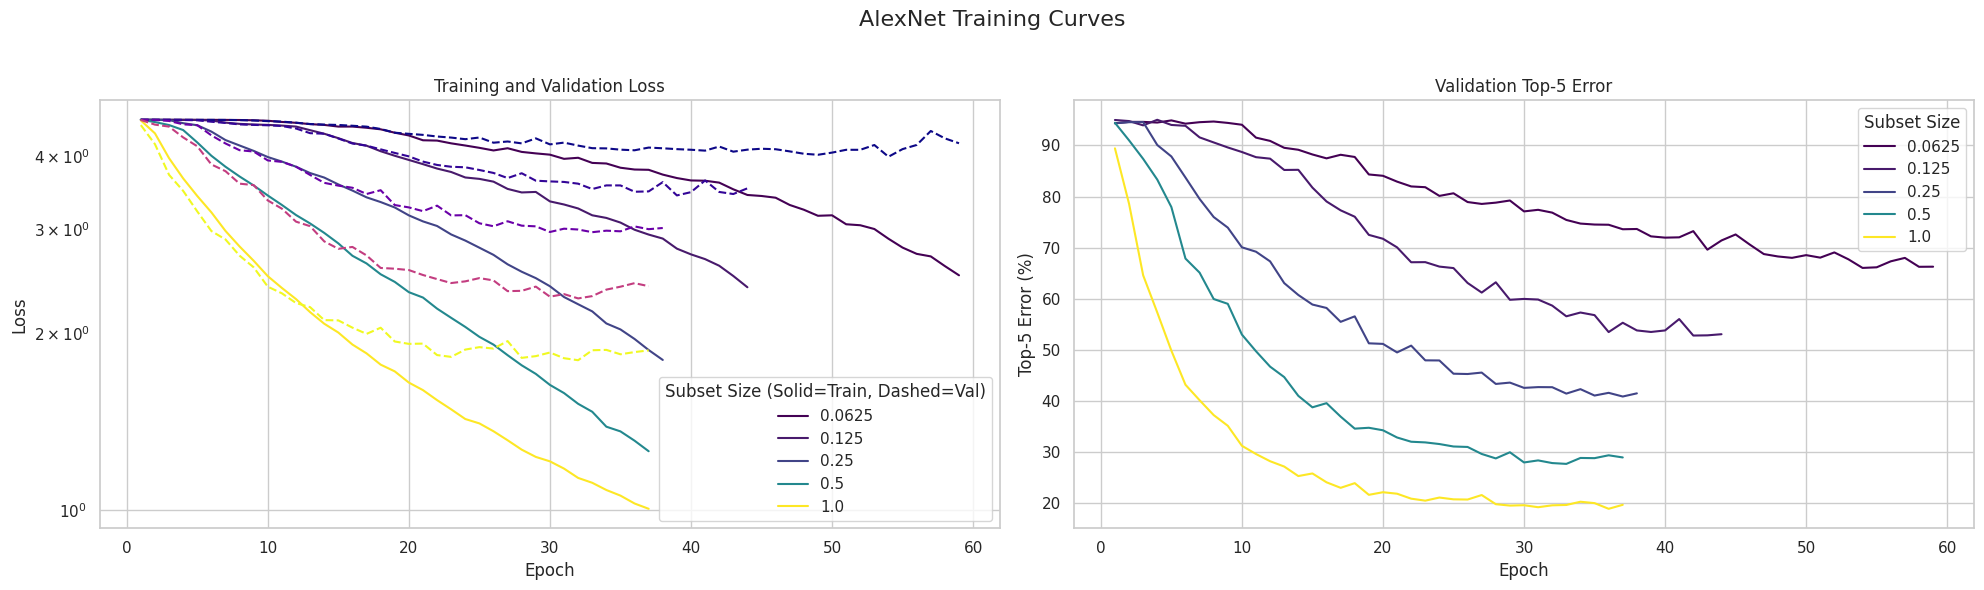

In [23]:
alexnet_logs_df = load_training_logs(alexnet_logs_dir)
plot_training_curves(alexnet_logs_df, 'AlexNet')

### ResNet-18 Training Curves

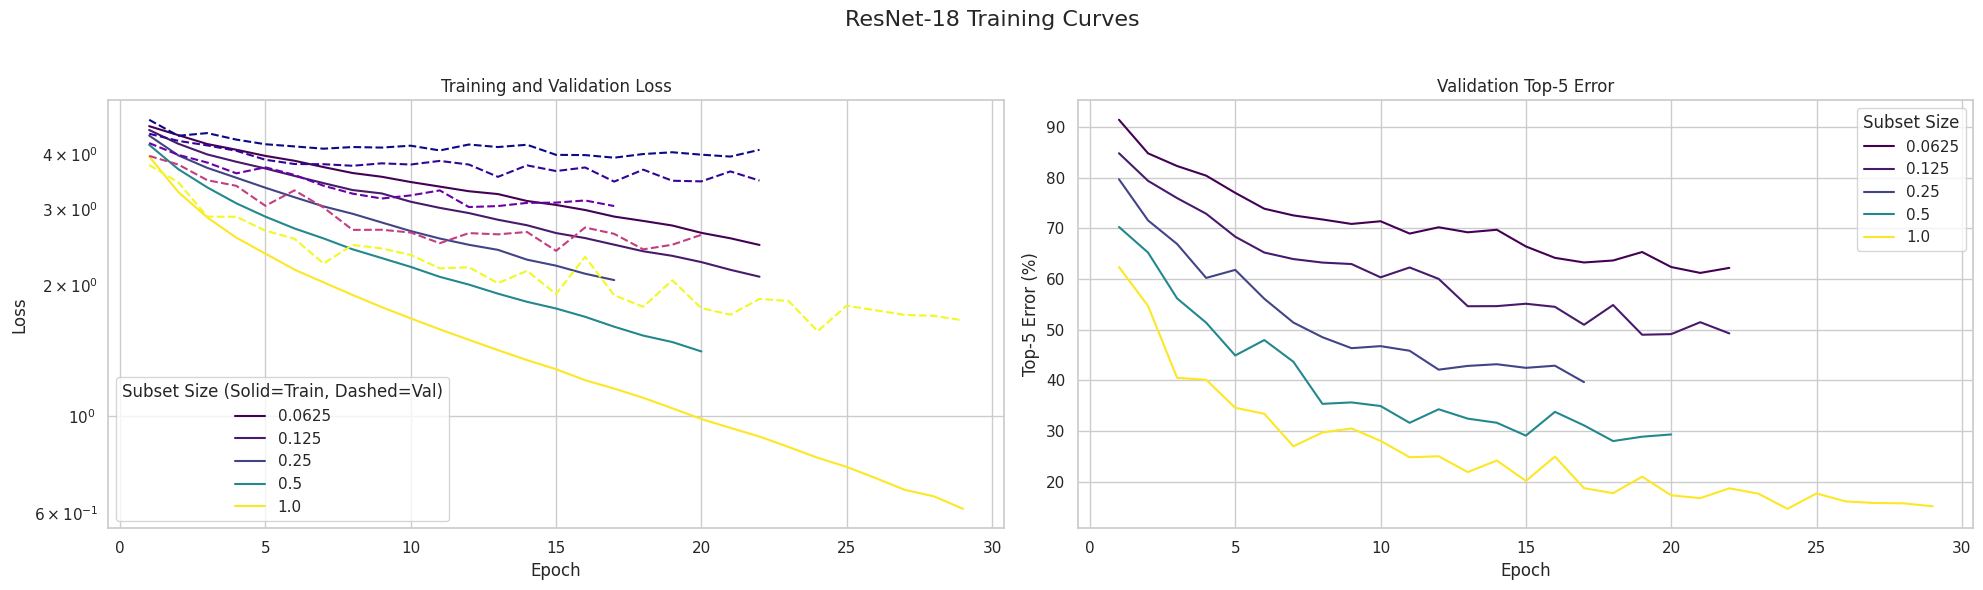

In [24]:
resnet18_logs_df = load_training_logs(resnet18_logs_dir)
plot_training_curves(resnet18_logs_df, 'ResNet-18')

## 3. Final Performance Comparison

Here, we load the final evaluation results generated by `eval.py` and plot the Top-1 and Top-5 errors for both models as a function of the training dataset size. This helps visualize the scaling laws and compare the data efficiency of the two architectures.

In [28]:
def load_evaluation_results(file_path: Path, model_name: str):
    """Load evaluation results from the JSON export file."""
    if not file_path.exists():
        print(f"Warning: Evaluation file not found at {file_path}")
        return pd.DataFrame()
    
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    df = pd.DataFrame(data)
    df['model'] = model_name
    # Convert subset size to percentage for plotting
    df['subset_percent'] = df['subset_sizes'] * 100
    return df

In [29]:
alexnet_results_df = load_evaluation_results(alexnet_results_file, "AlexNet")
display(alexnet_results_df)

,subset_sizes,top-5-error,top-1-accuracy,top-1-error,top-5-accuracy,model,subset_percent
0,0.0625,66.820000,12.780000,87.220000,33.180000,AlexNet,6.25
1,0.1250,55.000000,20.660000,79.340000,45.000000,AlexNet,12.50
2,0.2500,43.420002,29.439999,70.560001,56.579998,AlexNet,25.00
3,0.5000,30.040001,43.119999,56.880001,69.959999,AlexNet,50.00
4,1.0000,21.300003,53.619999,46.380001,78.699997,AlexNet,100.00


In [30]:
resnet18_results_df = load_evaluation_results(resnet18_results_file, "ResNet-18")
display(resnet18_results_df)

,subset_sizes,top-5-error,top-1-accuracy,top-1-error,top-5-accuracy,model,subset_percent
0,0.0625,64.020000,13.639999,86.360001,35.980000,ResNet-18,6.25
1,0.1250,51.680000,21.980000,78.020000,48.320000,ResNet-18,12.50
2,0.2500,44.160000,26.639999,73.360001,55.840000,ResNet-18,25.00
3,0.5000,29.520004,41.020000,58.980000,70.479996,ResNet-18,50.00
4,1.0000,15.400002,59.379997,40.620003,84.599998,ResNet-18,100.00


In [26]:
def plot_comparison_chart(df: pd.DataFrame):
    """Plot a line chart comparing model performance vs. dataset size."""
    if df.empty:
        print("No data available for comparison plot.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True)
    fig.suptitle('Model Performance vs. Training Data Size', fontsize=18)

    # Plot 1: Top-1 Error
    sns.lineplot(data=df, x='subset_percent', y='top-1-error', hue='model', marker='o', ax=axes[0])
    axes[0].set_title('Top-1 Error vs. Data Size')
    axes[0].set_ylabel('Top-1 Error (%)')
    axes[0].set_xlabel('Training Data Subset Size (%)')
    axes[0].set_xscale('log')
    axes[0].grid(True, which="both", ls="--")
    axes[0].legend(title='Model')

    # Plot 2: Top-5 Error
    sns.lineplot(data=df, x='subset_percent', y='top-5-error', hue='model', marker='o', ax=axes[1])
    axes[1].set_title('Top-5 Error vs. Data Size')
    axes[1].set_ylabel('Top-5 Error (%)')
    axes[1].set_xlabel('Training Data Subset Size (%)')
    axes[1].set_xscale('log')
    axes[1].grid(True, which="both", ls="--")
    axes[1].legend(title='Model')

    # Set ticks to correspond to the actual data points on the log scale
    # and format them as percentages.
    from matplotlib.ticker import ScalarFormatter
    ticks = sorted(df['subset_percent'].unique())
    for ax in axes:
        ax.set_xticks(ticks)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

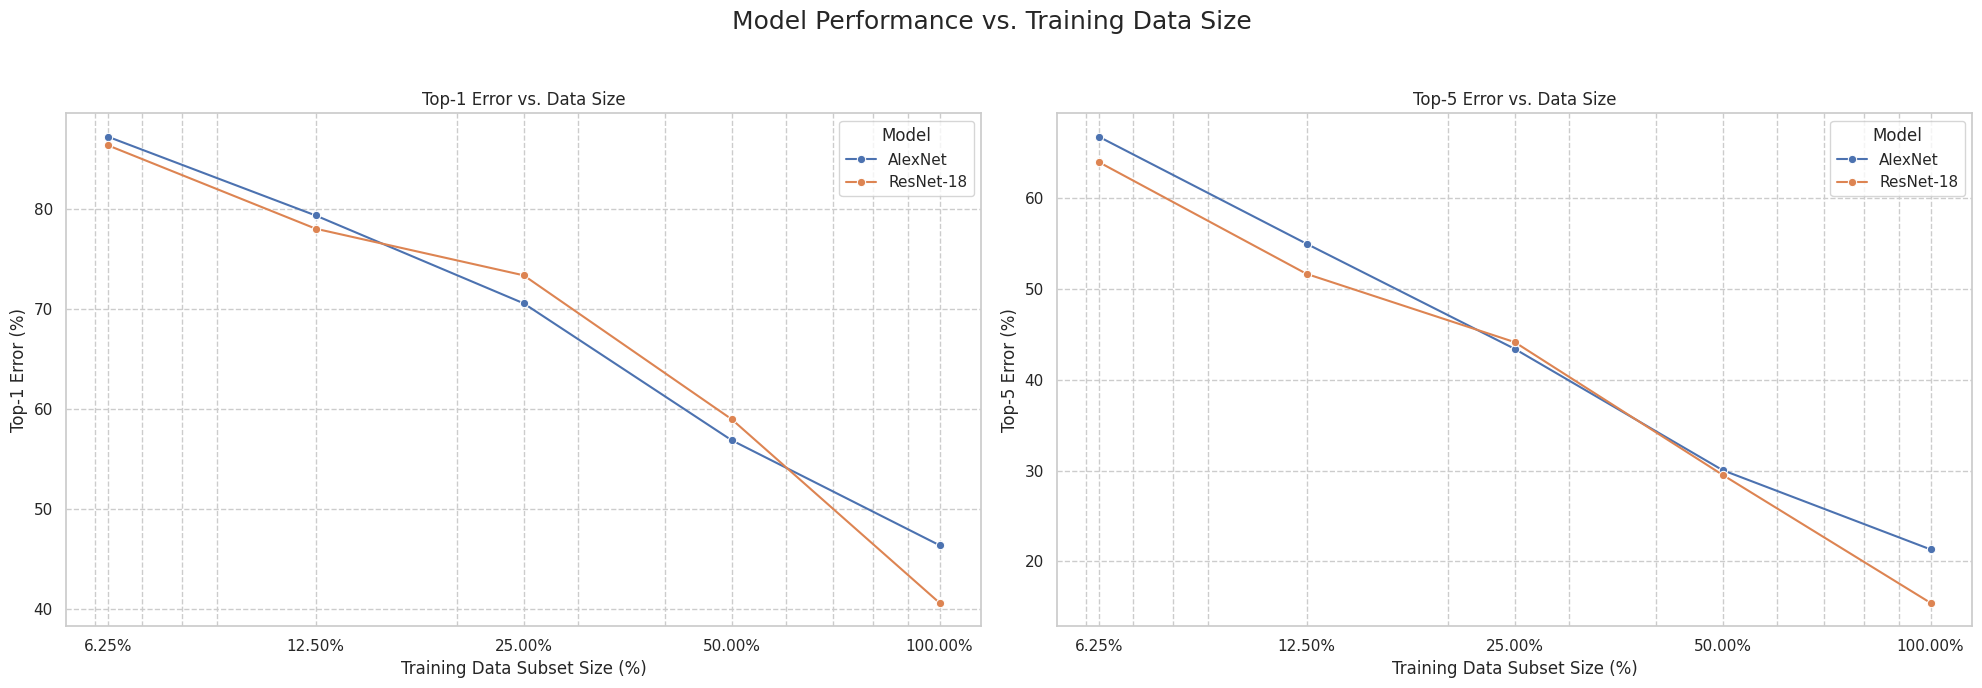

In [27]:
plot_comparison_chart(comparison_df)